In [1]:
import pandas as pd
import numpy as np
from torch import nn
import torch
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    AdamW
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import json
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Global variables for easy access
DATASET_PATH = 'News_Category_Dataset_v3.json'
MAX_LENGTH = 128  # Reduced from 512 for faster processing
BATCH_SIZE = 32   # Increased batch size for faster training
EPOCHS = 3        # Reduced epochs for quicker results

In [4]:
reviews = pd.read_json('news_category_trainingdata.json')
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

sample_amount = 6694
healthy = reviews[reviews['healthy'] == 1]
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)
review_sample = pd.concat([healthy,not_healthy])

target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

In [3]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=MAX_LENGTH):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [4]:
class ModelTrainer:
    def __init__(self, model_name, num_labels):
        self.model_name = model_name
        
        if 'bert-base-uncased' in model_name:
            self.tokenizer = BertTokenizer.from_pretrained(model_name)
            self.model = BertForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            ).to(DEVICE)
        elif 'roberta-base' in model_name:
            self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
            self.model = RobertaForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            ).to(DEVICE)
        elif 'distilbert-base-uncased' in model_name:
            self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
            self.model = DistilBertForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            ).to(DEVICE)
    
    def train(self, train_dataloader, val_dataloader):
        optimizer = AdamW(self.model.parameters(), lr=2e-5)
        
        best_val_loss = float('inf')
        for epoch in range(EPOCHS):
            # Training
            self.model.train()
            total_train_loss = 0
            
            for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{EPOCHS}'):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                optimizer.zero_grad()
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                total_train_loss += loss.item()
                
                loss.backward()
                optimizer.step()
            
            # Quick validation
            val_loss = self._validate(val_dataloader)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                # Save best model
                torch.save(self.model.state_dict(), f'best_{self.model_name.split("/")[-1]}.pt')
            
            print(f'Epoch {epoch + 1}: Train Loss = {total_train_loss/len(train_dataloader):.4f}, Val Loss = {val_loss:.4f}')
    
    def _validate(self, val_dataloader):
        self.model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                total_val_loss += outputs.loss.item()
        
        return total_val_loss / len(val_dataloader)
    
    def evaluate(self, test_dataloader, label_names):
        self.model.eval()
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc='Testing'):
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                preds = torch.argmax(outputs.logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        return classification_report(
            true_labels,
            predictions,
            target_names=label_names,
            output_dict=True
        )
    
    def predict(self, text, label_map):
        self.model.eval()
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=MAX_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(DEVICE)
        attention_mask = encoding['attention_mask'].to(DEVICE)
        
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = torch.argmax(outputs.logits, dim=1)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            
        predicted_label = list(label_map.keys())[prediction.item()]
        confidence = probabilities.max().item()
        
        return predicted_label, confidence

In [5]:
def prepare_data():
    print("Loading dataset...")
    df = pd.read_json(DATASET_PATH, lines=True)
    
    # Combine headline and description
    df['text'] = df['headline'] + ' [SEP] ' + df['short_description']
    
    # Convert categories to numerical labels
    label_map = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    df['label'] = df['category'].map(label_map)
    
    # Take a smaller subset for faster training
    df = df.sample(n=50000, random_state=42)  # Using 50k samples instead of full dataset
    
    # Split the data
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['text'].values, df['label'].values, test_size=0.3, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )
    
    return (
        train_texts, val_texts, test_texts,
        train_labels, val_labels, test_labels,
        label_map
    )

In [6]:
def main():
    # Prepare data
    train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, label_map = prepare_data()
    
    # Model configurations
    models = [
        ('bert-base-uncased', 'BERT'),
        ('roberta-base', 'RoBERTa'),
        ('distilbert-base-uncased', 'DistilBERT')
    ]
    
    results = {}
    trained_models = {}
    
    for model_name, model_type in models:
        print(f'\nTraining {model_type}...')
        trainer = ModelTrainer(model_name, len(label_map))
        
        # Create datasets
        train_dataset = NewsDataset(train_texts, train_labels, trainer.tokenizer)
        val_dataset = NewsDataset(val_texts, val_labels, trainer.tokenizer)
        test_dataset = NewsDataset(test_texts, test_labels, trainer.tokenizer)
        
        # Create dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
        
        # Train and evaluate
        trainer.train(train_dataloader, val_dataloader)
        metrics = trainer.evaluate(test_dataloader, list(label_map.keys()))
        
        results[model_type] = metrics
        trained_models[model_type] = trainer
        
        print(f"\n{model_type} Results:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Macro F1: {metrics['macro avg']['f1-score']:.4f}")
        print(f"Weighted F1: {metrics['weighted avg']['f1-score']:.4f}")
    
    return trained_models, label_map

In [7]:
# Function to make predictions
def predict_category(models, label_map, text):
    results = {}
    for model_name, model in models.items():
        category, confidence = model.predict(text, label_map)
        results[model_name] = {'category': category, 'confidence': confidence}
    return results

if __name__ == "__main__":
    # Train models and get predictions
    trained_models, label_map = main()
    
    # Example prediction
    sample_text = "Scientists discover new species in Amazon rainforest"
    predictions = predict_category(trained_models, label_map, sample_text)
    
    print("\nPrediction Results:")
    for model_name, result in predictions.items():
        print(f"\n{model_name}:")
        print(f"Predicted Category: {result['category']}")
        print(f"Confidence: {result['confidence']:.4f}")

Loading dataset...

Training BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/chjonte97/miniconda3/envs/torch-nlp/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 1094/1094 [12:50<00:00,  1.42it/s]


Epoch 1: Train Loss = 1.8652, Val Loss = 1.3706


Epoch 2/3: 100%|██████████| 1094/1094 [17:45<00:00,  1.03it/s]


Epoch 2: Train Loss = 1.1294, Val Loss = 1.2354


Epoch 3/3: 100%|██████████| 1094/1094 [17:22<00:00,  1.05it/s]


Epoch 3: Train Loss = 0.8082, Val Loss = 1.2645


Testing: 100%|██████████| 235/235 [01:28<00:00,  2.65it/s]



BERT Results:
Accuracy: 0.6640
Macro F1: 0.5338
Weighted F1: 0.6543

Training RoBERTa...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/chjonte97/miniconda3/envs/torch-nlp/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 1094/1094 [18:08<00:00,  1.00it/s]


Epoch 1: Train Loss = 1.6902, Val Loss = 1.2364


Epoch 2/3: 100%|██████████| 1094/1094 [14:22<00:00,  1.27it/s]


Epoch 2: Train Loss = 1.0845, Val Loss = 1.1582


Epoch 3/3: 100%|██████████| 1094/1094 [17:51<00:00,  1.02it/s]


Epoch 3: Train Loss = 0.8467, Val Loss = 1.1575


Testing: 100%|██████████| 235/235 [01:22<00:00,  2.87it/s]



RoBERTa Results:
Accuracy: 0.6691
Macro F1: 0.5545
Weighted F1: 0.6678

Training DistilBERT...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.outpu

Epoch 1: Train Loss = 2.9167, Val Loss = 2.5752


Epoch 2/3: 100%|██████████| 1094/1094 [17:30<00:00,  1.04it/s]


Epoch 2: Train Loss = 2.2841, Val Loss = 2.1047


Epoch 3/3: 100%|██████████| 1094/1094 [17:01<00:00,  1.07it/s]


Epoch 3: Train Loss = 1.8220, Val Loss = 1.9087


Testing: 100%|██████████| 235/235 [01:31<00:00,  2.57it/s]
/home/chjonte97/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chjonte97/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chjonte97/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi


DistilBERT Results:
Accuracy: 0.4971
Macro F1: 0.2561
Weighted F1: 0.4568

Prediction Results:

BERT:
Predicted Category: GREEN
Confidence: 0.5893

RoBERTa:
Predicted Category: GREEN
Confidence: 0.5741

DistilBERT:
Predicted Category: GREEN
Confidence: 0.1629


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_accuracy_comparison(results):
    """Plot accuracy comparison between models"""
    plt.figure(figsize=(10, 6))
    accuracies = {model: results[model]['accuracy'] for model in results}
    
    # Create bar plot
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Set y-axis from 0 to 1
    
    # Add value labels on top of each bar
    for i, (model, acc) in enumerate(accuracies.items()):
        plt.text(i, acc, f'{acc:.3f}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_f1_comparison(results):
    """Plot F1 scores comparison between models"""
    plt.figure(figsize=(12, 6))
    
    f1_scores = {
        model: {
            'Macro F1': results[model]['macro avg']['f1-score'],
            'Weighted F1': results[model]['weighted avg']['f1-score']
        } for model in results
    }
    
    df = pd.DataFrame(f1_scores).T
    df.plot(kind='bar', width=0.8)
    
    plt.title('F1 Score Comparison')
    plt.ylabel('F1 Score')
    plt.xlabel('Models')
    plt.legend(title='Metric Type')
    plt.ylim(0, 1)
    
    # Add value labels
    for i in range(len(df)):
        for j in range(len(df.columns)):
            plt.text(i, df.iloc[i, j], f'{df.iloc[i, j]:.3f}', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_category_performance(results, top_n=10):
    """Plot per-category F1 scores for top N categories"""
    plt.figure(figsize=(15, 8))
    
    # Get per-category F1 scores for each model
    category_scores = {}
    for model in results:
        # Filter out special keys like 'accuracy', 'macro avg', etc.
        categories = {k: v['f1-score'] for k, v in results[model].items() 
                     if k not in ['accuracy', 'macro avg', 'weighted avg']}
        category_scores[model] = categories
    
    # Convert to DataFrame
    df = pd.DataFrame(category_scores)
    
    # Get top N categories by average F1 score
    top_categories = df.mean(axis=1).nlargest(top_n).index
    df_top = df.loc[top_categories]
    
    # Create heatmap
    sns.heatmap(df_top, annot=True, fmt='.3f', cmap='YlOrRd', 
                center=0.5, vmin=0, vmax=1)
    plt.title(f'F1 Scores for Top {top_n} Categories')
    plt.ylabel('Categories')
    plt.xlabel('Models')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(predictions, true_labels, label_map, models):
    """Plot confusion matrices for each model"""
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(20, 6))
    
    # If there's only one model, wrap axes in a list
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, model_preds) in zip(axes, predictions.items()):
        # Create confusion matrix
        cm = confusion_matrix(true_labels, model_preds)
        
        # Plot
        sns.heatmap(cm, ax=ax, cmap='Blues', fmt='d',
                    xticklabels=False, yticklabels=False)
        ax.set_title(f'{model_name}\nConfusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training and validation losses over epochs"""
    plt.figure(figsize=(10, 6))
    
    for model_name, model_history in history.items():
        plt.plot(model_history['train_loss'], label=f'{model_name} (Train)',
                marker='o')
        plt.plot(model_history['val_loss'], label=f'{model_name} (Val)',
                marker='s', linestyle='--')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_prediction_confidence(predictions):
    """Plot confidence distribution for each model's predictions"""
    plt.figure(figsize=(12, 6))
    
    confidence_data = {model: pred['confidence'] for model, pred in predictions.items()}
    plt.bar(confidence_data.keys(), confidence_data.values())
    
    plt.title('Prediction Confidence by Model')
    plt.ylabel('Confidence Score')
    plt.ylim(0, 1)
    
    # Add value labels
    for i, (model, conf) in enumerate(confidence_data.items()):
        plt.text(i, conf, f'{conf:.3f}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_summary_report(results):
    """Create a summary DataFrame of model performances"""
    summary_data = []
    
    for model in results:
        model_data = {
            'Model': model,
            'Accuracy': results[model]['accuracy'],
            'Macro F1': results[model]['macro avg']['f1-score'],
            'Weighted F1': results[model]['weighted avg']['f1-score'],
            'Precision': results[model]['weighted avg']['precision'],
            'Recall': results[model]['weighted avg']['recall']
        }
        summary_data.append(model_data)
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.set_index('Model')
    
    return summary_df.round(4)

Loading dataset...

Evaluating BERT for visualization...


Testing: 100%|██████████| 235/235 [00:31<00:00,  7.40it/s]



Evaluating RoBERTa for visualization...


Testing: 100%|██████████| 235/235 [00:29<00:00,  8.07it/s]



Evaluating DistilBERT for visualization...


Testing: 100%|██████████| 235/235 [00:56<00:00,  4.16it/s]
/home/chjonte97/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chjonte97/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chjonte97/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

<Figure size 1200x600 with 0 Axes>

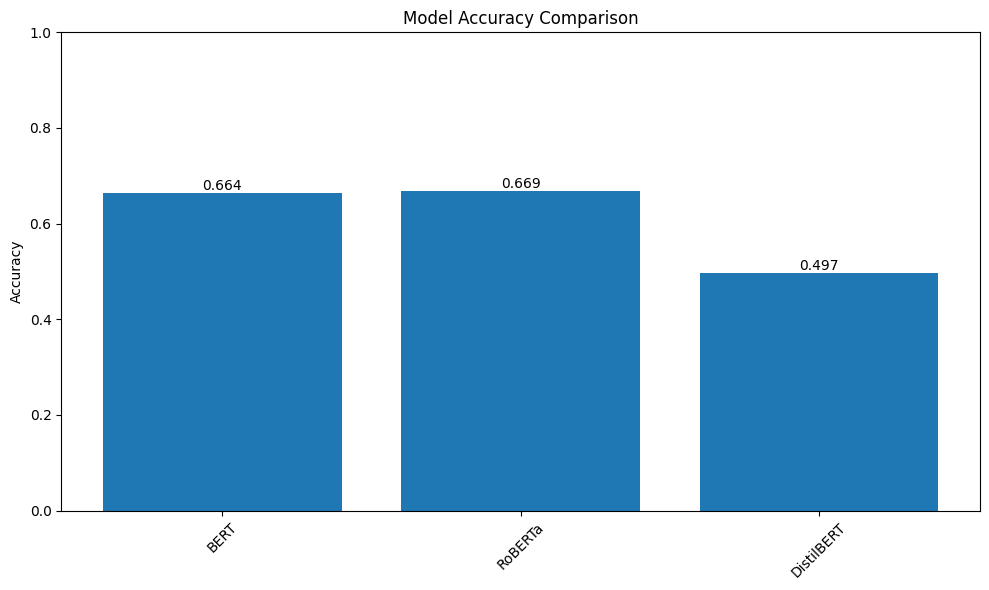

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

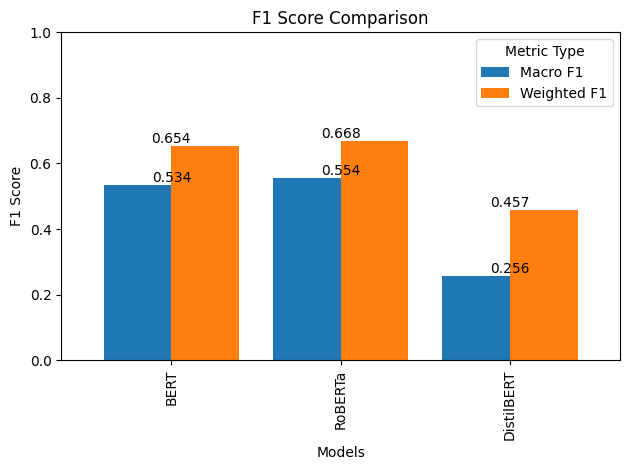

<Figure size 1500x800 with 0 Axes>

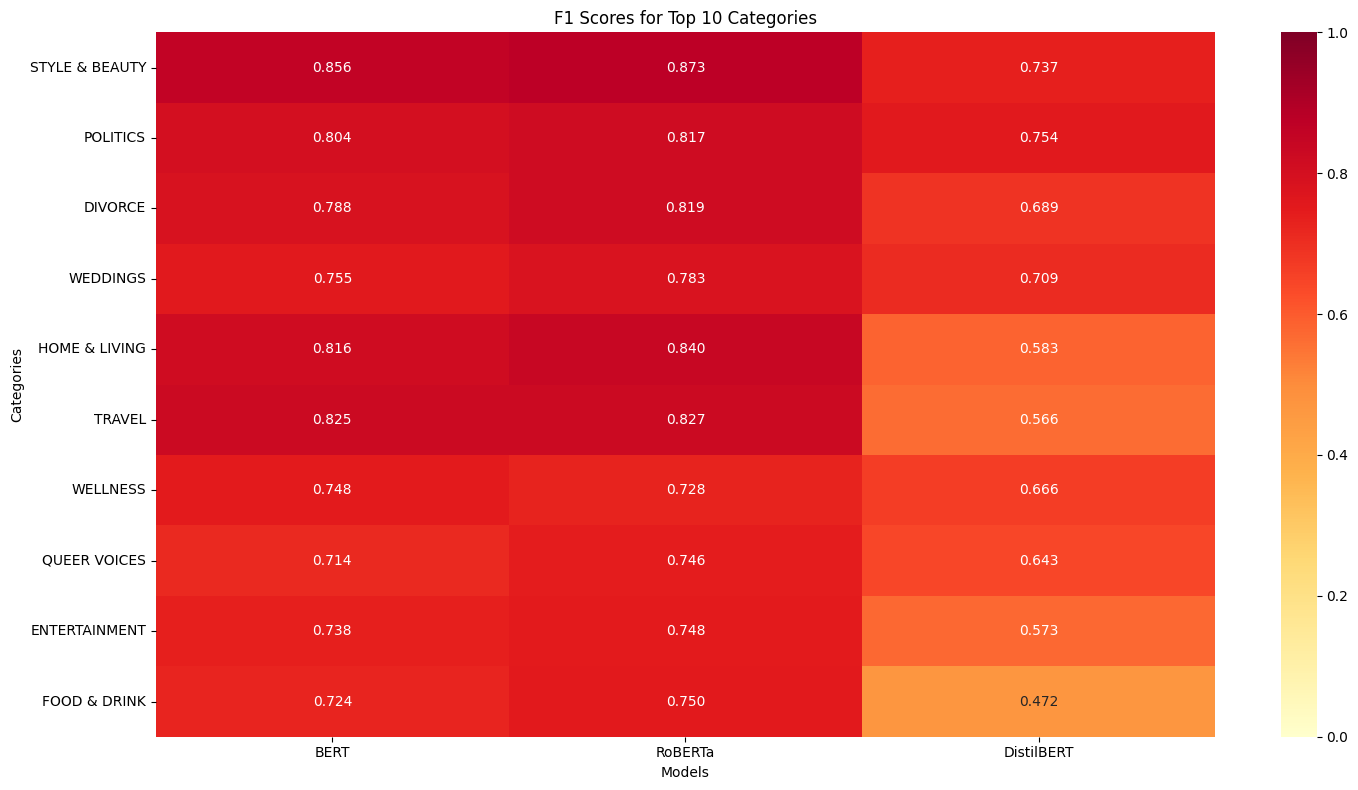


Model Performance Summary:
            Accuracy  Macro F1  Weighted F1  Precision  Recall
Model                                                         
BERT          0.6640    0.5338       0.6543     0.6595  0.6640
RoBERTa       0.6691    0.5545       0.6678     0.6750  0.6691
DistilBERT    0.4971    0.2561       0.4568     0.4727  0.4971


<Figure size 1000x600 with 0 Axes>

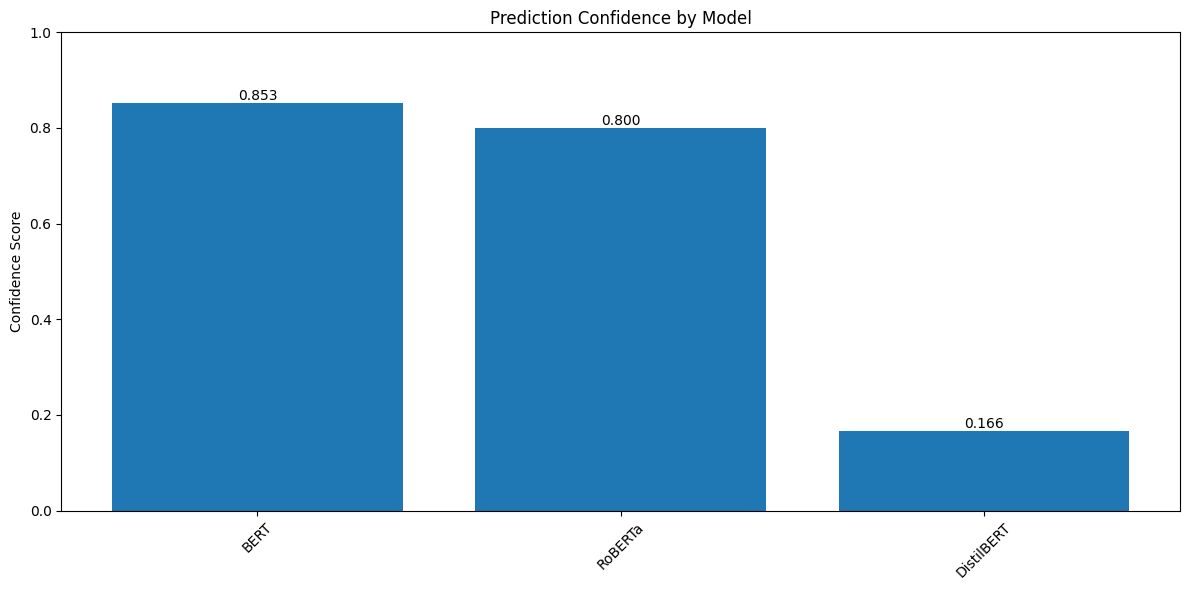

In [13]:
# First, get the data again
def prepare_data():
    print("Loading dataset...")
    df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
    
    # Combine headline and description
    df['text'] = df['headline'] + ' [SEP] ' + df['short_description']
    
    # Convert categories to numerical labels
    label_map = {cat: idx for idx, cat in enumerate(df['category'].unique())}
    df['label'] = df['category'].map(label_map)
    
    # Take a smaller subset for faster training
    df = df.sample(n=50000, random_state=42)  # Using 50k samples instead of full dataset
    
    # Split the data
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['text'].values, df['label'].values, test_size=0.3, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )
    
    return (
        train_texts, val_texts, test_texts,
        train_labels, val_labels, test_labels,
        label_map
    )

# Get the data
train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, label_map = prepare_data()

# Get results from trained models for visualization
results = {}
for model_type in trained_models:
    print(f"\nEvaluating {model_type} for visualization...")
    # Create test dataset and dataloader
    test_dataset = NewsDataset(test_texts, test_labels, trained_models[model_type].tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # Get evaluation results
    results[model_type] = trained_models[model_type].evaluate(test_dataloader, list(label_map.keys()))

# Now plot the visualizations
plt.figure(figsize=(12, 6))
plot_accuracy_comparison(results)
plt.savefig('accuracy_comparison.png')
plt.close()

plt.figure(figsize=(12, 6))
plot_f1_comparison(results)
plt.savefig('f1_comparison.png')
plt.close()

plt.figure(figsize=(15, 8))
plot_category_performance(results, top_n=10)
plt.savefig('category_performance.png')
plt.close()

# Create and display summary report
summary_df = create_summary_report(results)
print("\nModel Performance Summary:")
print(summary_df)
summary_df.to_csv('model_performance_summary.csv')

# For prediction confidence visualization
test_text = "New breakthrough in quantum computing shows promise for future technology [SEP] Scientists have achieved a major milestone in quantum computing research"
predictions = predict_category(trained_models, label_map, test_text)
plt.figure(figsize=(10, 6))
plot_prediction_confidence(predictions)
plt.savefig('prediction_confidence.png')
plt.close()


Prediction Results for: Elon Musk bought an island in India
--------------------------------------------------

Input text: Elon Musk bought an island in India [SEP] The tech billionaire has reportedly purchased a private island for new Tesla manufacturing unit

Predictions:
--------------------------------------------------

BERT:
Predicted Category: BUSINESS
Confidence: 0.3403 (34.03%)

RoBERTa:
Predicted Category: TECH
Confidence: 0.4544 (45.44%)

DistilBERT:
Predicted Category: TRAVEL
Confidence: 0.2264 (22.64%)

Comparative Results:
--------------------------------------------------
           Predicted Category       Confidence
Model                                         
BERT                 BUSINESS  0.3403 (34.03%)
RoBERTa                  TECH  0.4544 (45.44%)
DistilBERT             TRAVEL  0.2264 (22.64%)


<Figure size 1000x600 with 0 Axes>

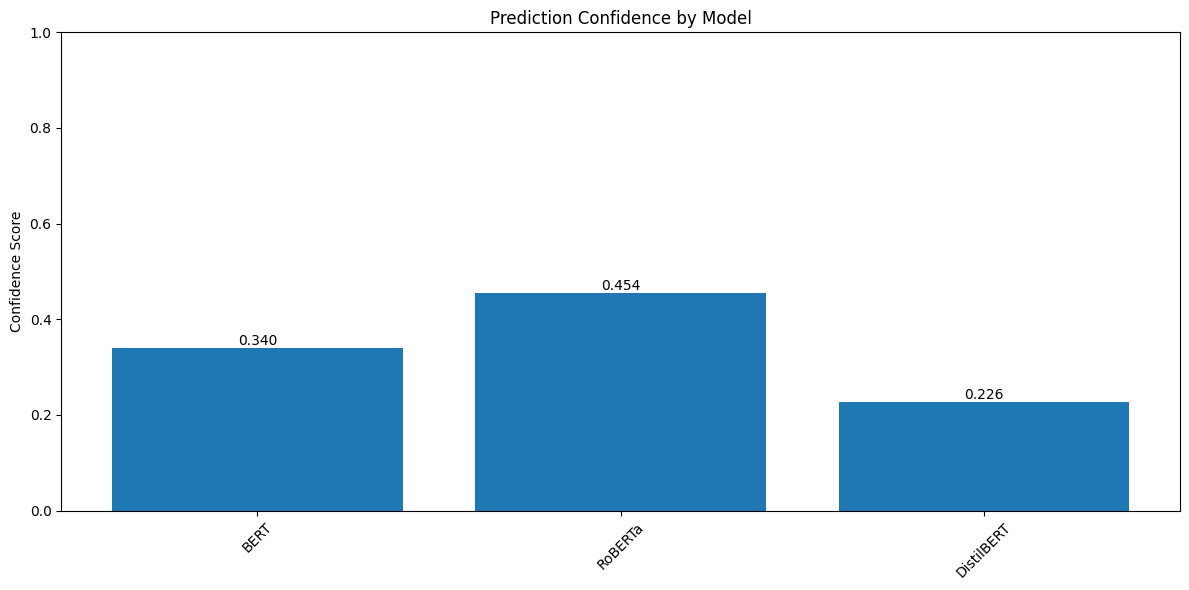

In [14]:
# Sample text for prediction
headline = "Elon Musk bought an island in India"
description = "The tech billionaire has reportedly purchased a private island for new Tesla manufacturing unit"
test_text = headline + " [SEP] " + description

# Get predictions from all models
predictions = predict_category(trained_models, label_map, test_text)

# Display predictions in a formatted way
print("\nPrediction Results for:", headline)
print("-" * 50)
print("\nInput text:", test_text)
print("\nPredictions:")
print("-" * 50)
for model_name, result in predictions.items():
    print(f"\n{model_name}:")
    print(f"Predicted Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.4f} ({result['confidence']*100:.2f}%)")

# Create a DataFrame for better visualization
pred_df = pd.DataFrame([
    {
        'Model': model_name,
        'Predicted Category': result['category'],
        'Confidence': f"{result['confidence']:.4f} ({result['confidence']*100:.2f}%)"
    }
    for model_name, result in predictions.items()
])
pred_df = pred_df.set_index('Model')
print("\nComparative Results:")
print("-" * 50)
print(pred_df)

# Visualize confidence scores
plt.figure(figsize=(10, 6))
plot_prediction_confidence(predictions)